In [67]:
import numpy as np
import pandas as pd
import textblob

import seaborn
from matplotlib import pyplot

import string
from textblob import TextBlob, Word
import re
import nltk
nltk.download('wordnet')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn import datasets, ensemble
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import f1_score
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.svm import SVC

from sklearn.cluster import KMeans
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\yasmi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


**DATA CLEANING**

In [68]:
nlp_df= pd.read_csv("train.csv")
nlp_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [69]:
nlp_df[nlp_df['target']== 0]

,id,keyword,location,text,target
15,23,NaN,NaN,What's up man?,0
16,24,NaN,NaN,I love fruits,0
17,25,NaN,NaN,Summer is lovely,0
18,26,NaN,NaN,My car is so fast,0
19,28,NaN,NaN,What a goooooooaaaaaal!!!!!!,0
...,...,...,...,...,...
7581,10833,wrecked,Lincoln,@engineshed Great atmosphere at the British Li...,0
7582,10834,wrecked,NaN,Cramer: Iger's 3 words that wrecked Disney's s...,0
7584,10837,NaN,NaN,These boxes are ready to explode! Exploding Ki...,0
7587,10841,NaN,NaN,Sirens everywhere!,0


In [70]:
#checkdisastertonotdisasterratio
not_disaster_count= nlp_df['target'].value_counts()[0]
disaster_count= nlp_df['target'].value_counts()[1]
print (not_disaster_count)
print (disaster_count)

4342
3271


In [71]:
#check shape
nlp_df.shape

(7613, 5)

In [72]:
#checknans
locnull= nlp_df['location'].isnull().values.sum()
keywordnull= nlp_df['keyword'].isnull().values.sum()
print (locnull)
print (keywordnull)

2533
61


In [73]:
nlp_df= nlp_df.drop(columns= 'location')
nlp_df = nlp_df[nlp_df['keyword'].notna()]

In [74]:
#make lowercase
nlp_df['text']= nlp_df['text'].apply(str.lower)

In [75]:
#function to remove punctuation
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

In [76]:
#remove punctuation for easier parsing
nlp_df['text']= nlp_df['text'].apply(remove_punctuations)

In [77]:
#helper function to remove url
def remove_url (text):
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    return (text)


In [78]:
#remove urls for better tokenization
nlp_df['text']= nlp_df['text'].apply(remove_url)

In [79]:
#helper function to lemmatize
def lem(text):
    
    list_empty=[]
    
    for i in text.split():
        w = Word(i)
        
        list_empty.append(w.lemmatize())
    #convert list to string
    string = " ".join(list_empty)
    
    return string

In [80]:
#apply lemmatization
nlp_df['text']= nlp_df['text'].apply(lem)
nlp_df

,id,keyword,text,target
31,48,ablaze,bbcmtd wholesale market ablaze httptcolhyxeohy6c,1
32,49,ablaze,we always try to bring the heavy metal rt http...,0
33,50,ablaze,africanbaze breaking newsnigeria flag set abla...,1
34,52,ablaze,cry out for more set me ablaze,0
35,53,ablaze,on plus side look at the sky last night it wa ...,0
...,...,...,...,...
7578,10830,wrecked,jtruff23 cameronhacker and i wrecked you both,0
7579,10831,wrecked,three day off from work and theyve pretty much...,0
7580,10832,wrecked,fx forex trading cramer igers 3 word that wrec...,0
7581,10833,wrecked,engineshed great atmosphere at the british lio...,0


**Weighting and rudimentary analysis:**

In [81]:
count_vectorizer = CountVectorizer()
word_counts= count_vectorizer.fit_transform(nlp_df["text"])

In [82]:
count_vectorizer.inverse_transform(word_counts[0])

[array(['bbcmtd', 'wholesale', 'market', 'ablaze', 'httptcolhyxeohy6c'],
       dtype='<U52')]

In [83]:
print(np.shape(word_counts))
print(word_counts.nnz)

(7552, 21058)
101048


In [84]:
total_tokens = word_counts.sum()
word_totals = word_counts.sum(axis=0)
word_totals = np.ravel(word_totals)
print(word_totals.shape)
vocabulary = count_vectorizer.get_feature_names_out()
print("words that occur less than five times: ", len(vocabulary[np.where(word_totals < 5)]))

(21058,)
words that occur less than five times:  18375


total count:  10374
[(3250, 'the'), (1958, 'in'), (1938, 'to'), (1816, 'of'), (1412, 'and')]


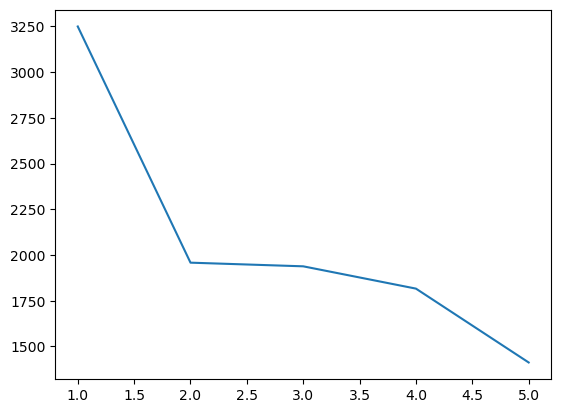

<AxesSubplot:>

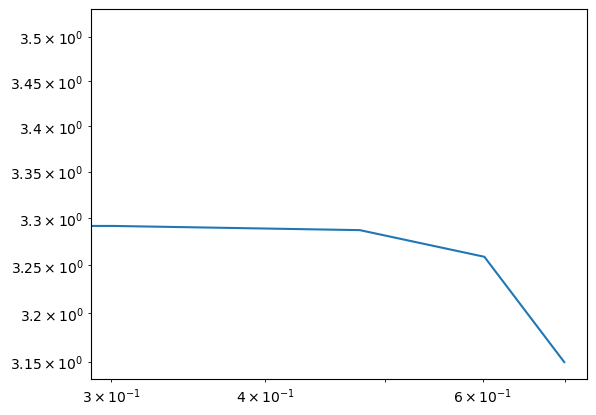

In [85]:
most_frequent_words = vocabulary[np.where(word_totals > 1000)]
most_frequent_word_counts = word_totals[np.where(word_totals > 1000)]

print("total count: ", most_frequent_word_counts.sum())
print(sorted(zip(most_frequent_word_counts, most_frequent_words), reverse=True))

seaborn.lineplot(x=range(len(most_frequent_words), 0, -1),
                 y=np.sort(most_frequent_word_counts))
pyplot.show()
pyplot.xscale('log')
pyplot.yscale('log')
seaborn.lineplot(x=range(len(most_frequent_words), 0, -1),
                 y=np.sort(most_frequent_word_counts))

In [86]:
tfidf_vectorizer= TfidfVectorizer(min_df= 20)
nlp_tfidf= tfidf_vectorizer.fit_transform(nlp_df["text"]).toarray()
tfidf_vocab_nlp= tfidf_vectorizer.get_feature_names_out()

In [87]:
#Combined keyword and text column
X = nlp_df
tfidf_vectorizer_other= TfidfVectorizer()
nlp_tfidf_other= make_column_transformer((tfidf_vectorizer, 'text'), (tfidf_vectorizer, 'keyword'))
nlp_tfidf_other= nlp_tfidf_other.fit_transform(X)

**Machine Learning**

In [88]:
#notencoded MNB
reviews_train, reviews_test, ratings_train, ratings_test = train_test_split (nlp_tfidf, nlp_df['target'], test_size=0.1, random_state= 0)
nb_classifier= MultinomialNB().fit(reviews_train, ratings_train)
print (nb_classifier.score(reviews_test, ratings_test))
print (nb_classifier.score(reviews_train, ratings_train))


0.794973544973545
0.8062095350206003


In [99]:
#encoded MNB
reviews_train, reviews_test, ratings_train, ratings_test = train_test_split (nlp_tfidf_other, nlp_df['target'], test_size=0.1, random_state= 0)
nb_classifier= MultinomialNB().fit(reviews_train, ratings_train)
print (nb_classifier.score(reviews_test, ratings_test))
print (nb_classifier.score(reviews_train, ratings_train))

0.7777777777777778
0.8041494997057093


In [89]:
pos_neg= nb_classifier.feature_log_prob_
a= pos_neg[0]-pos_neg[1]
tuple_list= zip(a, tfidf_vocab_nlp)
tuple_list= sorted(tuple_list)
for x in tuple_list[:50]:
        k= []
        k.append((round(x[0],2), x[1]))
for x in tuple_list[-50:]:
        k.append((round(x[0],2), x[1]))
        print (k)

[(-2.18, 'japan'), (1.31, 'obliterate')]
[(-2.18, 'japan'), (1.31, 'obliterate'), (1.32, 'screaming')]
[(-2.18, 'japan'), (1.31, 'obliterate'), (1.32, 'screaming'), (1.33, 'desolation')]
[(-2.18, 'japan'), (1.31, 'obliterate'), (1.32, 'screaming'), (1.33, 'desolation'), (1.35, 'screamed')]
[(-2.18, 'japan'), (1.31, 'obliterate'), (1.32, 'screaming'), (1.33, 'desolation'), (1.35, 'screamed'), (1.36, 'stretcher')]
[(-2.18, 'japan'), (1.31, 'obliterate'), (1.32, 'screaming'), (1.33, 'desolation'), (1.35, 'screamed'), (1.36, 'stretcher'), (1.36, 'inundated')]
[(-2.18, 'japan'), (1.31, 'obliterate'), (1.32, 'screaming'), (1.33, 'desolation'), (1.35, 'screamed'), (1.36, 'stretcher'), (1.36, 'inundated'), (1.36, 'im')]
[(-2.18, 'japan'), (1.31, 'obliterate'), (1.32, 'screaming'), (1.33, 'desolation'), (1.35, 'screamed'), (1.36, 'stretcher'), (1.36, 'inundated'), (1.36, 'im'), (1.38, 'bloody')]
[(-2.18, 'japan'), (1.31, 'obliterate'), (1.32, 'screaming'), (1.33, 'desolation'), (1.35, 'screamed

In [90]:
nlp_train, nlp_test, target_train, target_test = train_test_split (nlp_df['text'], nlp_df['target'], test_size=0.1, random_state= 0)

vectorizer = CountVectorizer(min_df=20)

x_train = vectorizer.fit_transform(nlp_train)
x_test = vectorizer.transform(nlp_test)

# LOGISTIC REGRESSION, not encoded
logreg = LogisticRegression()
logreg.fit(x_train, target_train)
lr_test_prediction = logreg.predict(x_test)
lr_train_prediction= logreg.predict(x_train)
print ('train predcition')
print (np.mean(lr_train_prediction == target_train))
print ('test prediction')
print (np.mean(lr_test_prediction == target_test))

train predcition
0.8435844614479105
test prediction
0.7764550264550265


In [100]:
#LogisticRegression encoded
nlp_train, nlp_test, target_train, target_test = train_test_split (nlp_df['text'], nlp_df['target'], test_size=0.1, random_state= 0)
vectorizer= CountVectorizer()
X = nlp_df
ct= make_column_transformer((vectorizer, 'text'), (vectorizer, 'keyword'))
ct= ct.fit_transform(X)
x_train = vectorizer.fit_transform(nlp_train)
x_test = vectorizer.transform(nlp_test)

logreg = LogisticRegression()
logreg.fit(x_train, target_train)
lr_test_prediction = logreg.predict(x_test)
lr_train_prediction= logreg.predict(x_train)
print ('train predcition')
print (np.mean(lr_train_prediction == target_train))
print ('test prediction')
print (np.mean(lr_test_prediction == target_test))

train predcition
0.9686580341377281
test prediction
0.8042328042328042


c:\Users\yasmi\Anaconda3\envs\info2950\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [101]:
print ('train and test accuracy')
print (metrics.accuracy_score(target_train, lr_train_prediction))
print (metrics.accuracy_score(target_test, lr_test_prediction))
print ('train and test precision')
print (metrics.precision_score(target_train, lr_train_prediction))
print (metrics.precision_score(target_test, lr_test_prediction))
print ('train and test recall')
print (metrics.recall_score(target_train, lr_train_prediction))
print (metrics.recall_score(target_test, lr_test_prediction))
print ('train and test f1')
print (metrics.f1_score(target_train, lr_train_prediction))
print (metrics.f1_score(target_test, lr_test_prediction))

train and test accuracy
0.9686580341377281
0.8042328042328042
train and test precision
0.9870223503965393
0.8051470588235294
train and test recall
0.9392795883361921
0.697452229299363
train and test f1
0.9625593250131834
0.7474402730375426


**Our Prediction Tweets**

In [92]:
first_tweet= ['the spurs got absolutely obliterated. It was fucking beautiful.']
tfidf_vectorizer_first= tfidf_vectorizer.transform(first_tweet).toarray()
nb_classifier.predict(tfidf_vectorizer_first)

array([0], dtype=int64)

In [93]:
second_tweet= ['The earthquake in Turkey was a tragedy.']
tfidf_vectorizer_second= tfidf_vectorizer.transform(second_tweet).toarray()
nb_classifier.predict(tfidf_vectorizer_second)

array([1], dtype=int64)

In [94]:
second_tweet= ['The earthquake in Turkey was a tragedy.']
tfidf_vectorizer_second= vectorizer.transform(second_tweet).toarray()
logreg.predict(tfidf_vectorizer_second)

array([1], dtype=int64)

In [95]:
third_tweet= ["I'm used to being let down. i'm a knicks fan."]
tfidf_vectorizer_third= tfidf_vectorizer.transform(third_tweet).toarray()
nb_classifier.predict(tfidf_vectorizer_third)

array([0], dtype=int64)

**Looped through classifiers (TFID)**

In [102]:
classifiers= [DecisionTreeClassifier, LogisticRegression, MultinomialNB]

reviews_train, reviews_test, ratings_train, ratings_test = train_test_split (nlp_tfidf_other, nlp_df['target'], test_size=0.1, random_state= 0)

for clf in classifiers:
    classified= clf().fit(reviews_train, ratings_train)
    print ('tweet train score')
    print (classified.score(reviews_train, ratings_train))
    print ('tweet test score')
    print (classified.score(reviews_test, ratings_test))

tweet train score
0.9821954090641554
tweet test score
0.6785714285714286
tweet train score
0.84240729841083
tweet test score
0.7896825396825397
tweet train score
0.8041494997057093
tweet test score
0.7777777777777778


**Finetuning**

In [103]:
#For untransformed dataframe
#Makes most sense to use encoded text column with CountVectorizer for LogisticRegression model
logreg = LogisticRegression(penalty='elasticnet', dual=False, tol=0.01, 
                           C=1, fit_intercept=True, intercept_scaling=1.0, 
                           class_weight=None, random_state=None, solver='saga', l1_ratio=0)
logreg.fit(x_train, target_train)
lr_test_prediction = logreg.predict(x_test)
lr_train_prediction= logreg.predict(x_train)
print ('train predcition')
print (np.mean(lr_train_prediction == target_train))
print ('test prediction')
print (np.mean(lr_test_prediction == target_test))

train predcition
0.922160094173043
test prediction
0.8108465608465608


In [113]:
#For untransformed dataframe
#Makes most sense to use unencoded text column with TFIDVectorizer for MNB model
nb_classify= MultinomialNB(alpha=0)
reviews_train, reviews_test, ratings_train, ratings_test = train_test_split (nlp_tfidf, nlp_df['target'], test_size=0.1, random_state= 0)
nb_classifier= nb_classify.fit(reviews_train, ratings_train)
print (nb_classifier.score(reviews_test, ratings_test))
print (nb_classifier.score(reviews_train, ratings_train))


0.7883597883597884
0.8085638610947616


c:\Users\yasmi\Anaconda3\envs\info2950\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
